In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Виведемо гіпотезу.
Можна було використати для створення моделі показники ROA і ROE, але я вирішив розглянути конкурентоспроможність банку зі сторони його чистого процентного доходу.
На мою думку, основна спеціалізація банку це кредитна діяльність і її ефективність можна оцінити з точки зору чисто процентного доходу/витрат. Мною було виділено 4 признаки(feature) які лінійно кореляють з чистим процентним доходо: власний капітал, кошти клієнтів, кредити та заборгованість клієнтів, загальні активи.
Мною був сформований датасет з інформацією з наглядової статистики НБУ, за періоди 2019-2021р за 4 квартали кожного року. Тобто в датасеті повторюються дані тих самих банків тільки за різні періоди часу.

In [2]:
df = pd.read_csv("competition.csv")
df.head()


,Назва,Чистий процентний дохід/(Чисті процентні витрати),Усього власного капіталу,Кошти клієнтів,Кредити та заборгованість клієнтів,"Загальні активи, усього"
0,Банки з державною часткою,NaN,NaN,NaN,NaN,NaN
1,"АТ КБ ""ПРИВАТБАНК""","4,897,293","38,837,847","221,233,248","51,227,226","525,698,074"
2,"АТ ""ОЩАДБАНК""","1,598,882","18,659,366","156,225,001","34,181,907","279,640,085"
3,"АТ ""Укрексімбанк""","355,428","8,718,342","82,828,741","18,719,345","232,798,022"
4,"АБ ""УКРГАЗБАНК""","723,634","5,893,278","77,282,524","21,282,796","99,606,035"


In [3]:
df.shape

(949, 6)

In [4]:
df.dropna(inplace=True)

In [5]:
df.shape

(913, 6)

In [6]:
df.columns = ['name', 'net_interest_income_expense', 'total_equity', 'clients_money', 'loans_and_debts_of_customers', 'total_assets']
df.columns

Index(['name', 'net_interest_income_expense', 'total_equity', 'clients_money',
       'loans_and_debts_of_customers', 'total_assets'],
      dtype='object')

Усього по банках іноземних банківських груп, Усього по банках з державною часткою

In [7]:
total = df[(df.name == "Усього по банках з державною часткою") | (df.name == "Усього по банках іноземних банківських груп")]
df.drop(total.index, inplace=True)
df.shape

(889, 6)

Прибираємо з data frame назви банків, вони нам більше не потрібні.

In [8]:
df = df.loc[:,"net_interest_income_expense":]

Нам потрібно перевести данні в int, але перед цим потрібно прибрати з наших данних (які зараз object) коми.

In [9]:
df.replace(",", "", regex=True, inplace=True)
df = df.astype(int)
df.dtypes

net_interest_income_expense     int32
total_equity                    int32
clients_money                   int32
loans_and_debts_of_customers    int32
total_assets                    int32
dtype: object

В дадасеті є інформація по банківським установам, які не є зовсім банками: Розрахунковий центер,
    Український банк реконструкції і розвитку. У цих банківських установ кредитна заборгованість клієнтів == 0.

In [10]:
inncorect_data = df[df.loans_and_debts_of_customers == 0]
df.drop(inncorect_data.index, inplace=True)
df.shape

(868, 5)

Побудуємо графіки:

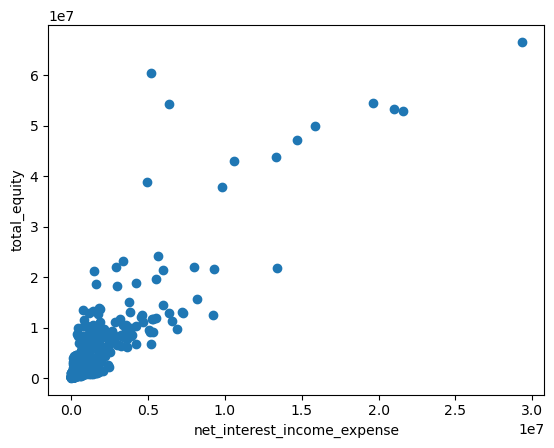

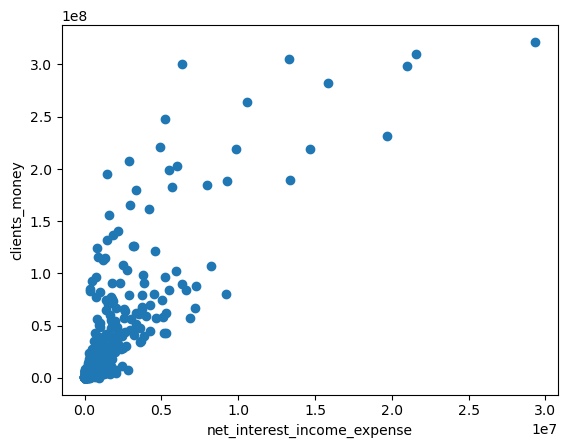

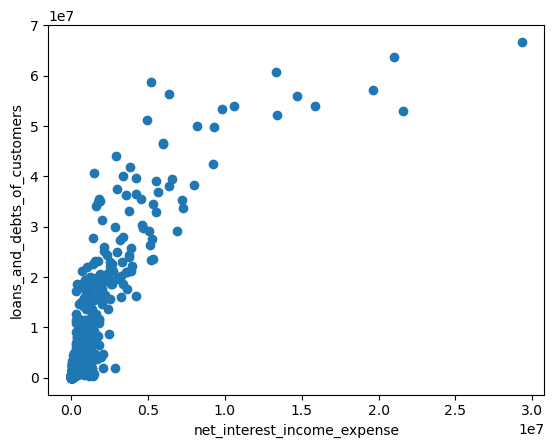

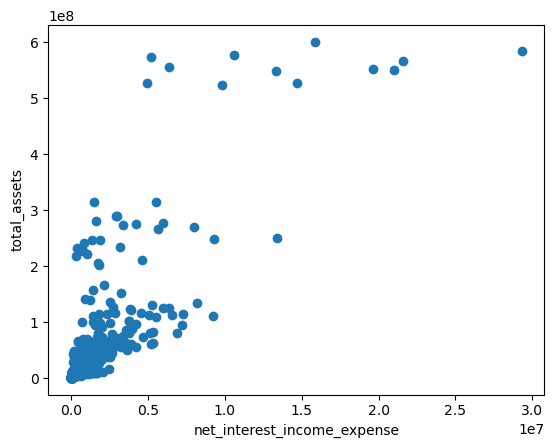

In [11]:
for collums in df.columns[1:]:
    plt.scatter(df['net_interest_income_expense'], df[collums])
    plt.xlabel('net_interest_income_expense')
    plt.ylabel(collums)
    plt.show()


Через те що більше половине банківського ринку зконцентровано в 3 найбільших банках, графіки не є сильно інформативними.
Давайте спробуємо їх прибрати з датасету і відмалювати знову.

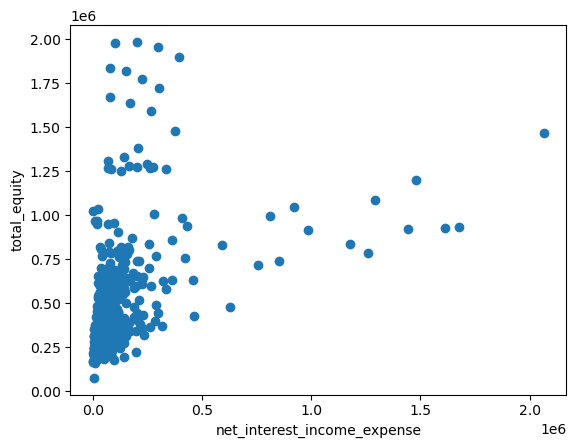

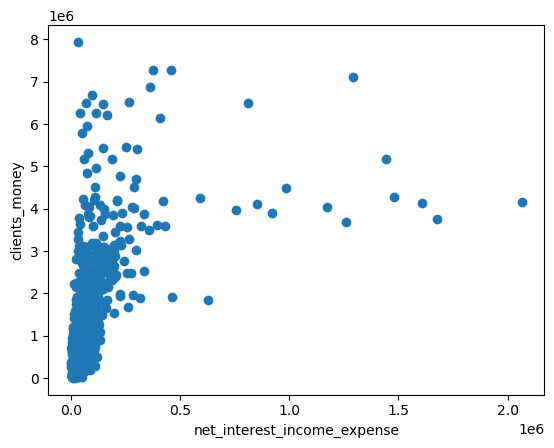

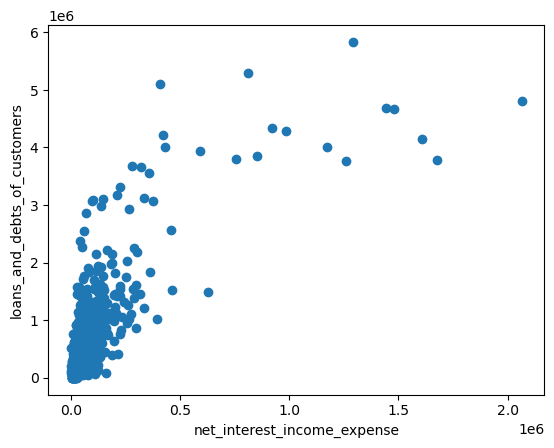

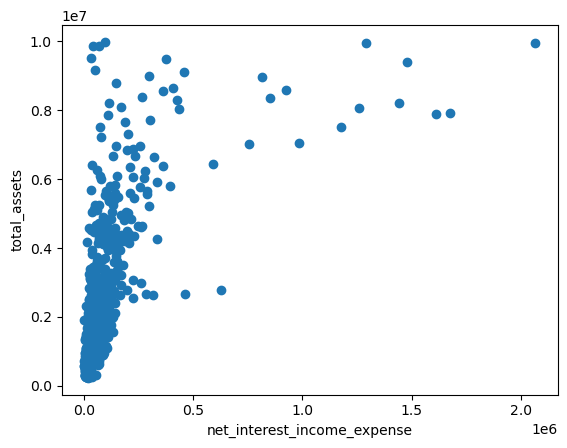

In [51]:
test_df = df[(df.total_assets < 10_000_000) & (df.net_interest_income_expense > 0)]

for collums in test_df.columns[1:]:
    plt.scatter(test_df['net_interest_income_expense'], test_df[collums])
    plt.xlabel('net_interest_income_expense')
    plt.ylabel(collums)
    plt.show()

In [52]:
correlation_matrix = df.corrwith(df['net_interest_income_expense'])
print(correlation_matrix)

net_interest_income_expense     1.000000
total_equity                    0.882710
clients_money                   0.836321
loans_and_debts_of_customers    0.832804
total_assets                    0.821046
dtype: float64


In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Розділити дані на вхідні змінні (X) та цільову змінну (y)
X = df[['total_equity', 'clients_money', 'loans_and_debts_of_customers', 'total_assets']]
y = df['net_interest_income_expense']

# Розділити дані на тренувальний та тестувальний набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ініціалізувати модель лінійної регресії
reg = LinearRegression()

# Навчити модель на тренувальних даних
reg.fit(X_train, y_train)

# Зробити прогноз на тестових даних
y_pred = reg.predict(X_test)

# Оцінити модель за допомогою середньо-квадратичної помилки (MSE)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print("MSE:", mse)
print("RMSE:", rmse)

MSE: 404335234571.71027
RMSE: 635873.5995240802


In [56]:
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(X_train,y_train)
feature_weights = zip(df.columns[1:], ridge.coef_)
for feature, weight in feature_weights:
    print(feature, weight)
    
y_pred_ridge = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred_ridge)
rmse = mse ** 0.5

print("MSE:", mse)
print("RMSE:", rmse)

total_equity 0.3565333424569775
clients_money 0.022071663590829054
loans_and_debts_of_customers 0.021540600642956223
total_assets -0.02055806863047502
MSE: 404335234571.71027
RMSE: 635873.5995240802


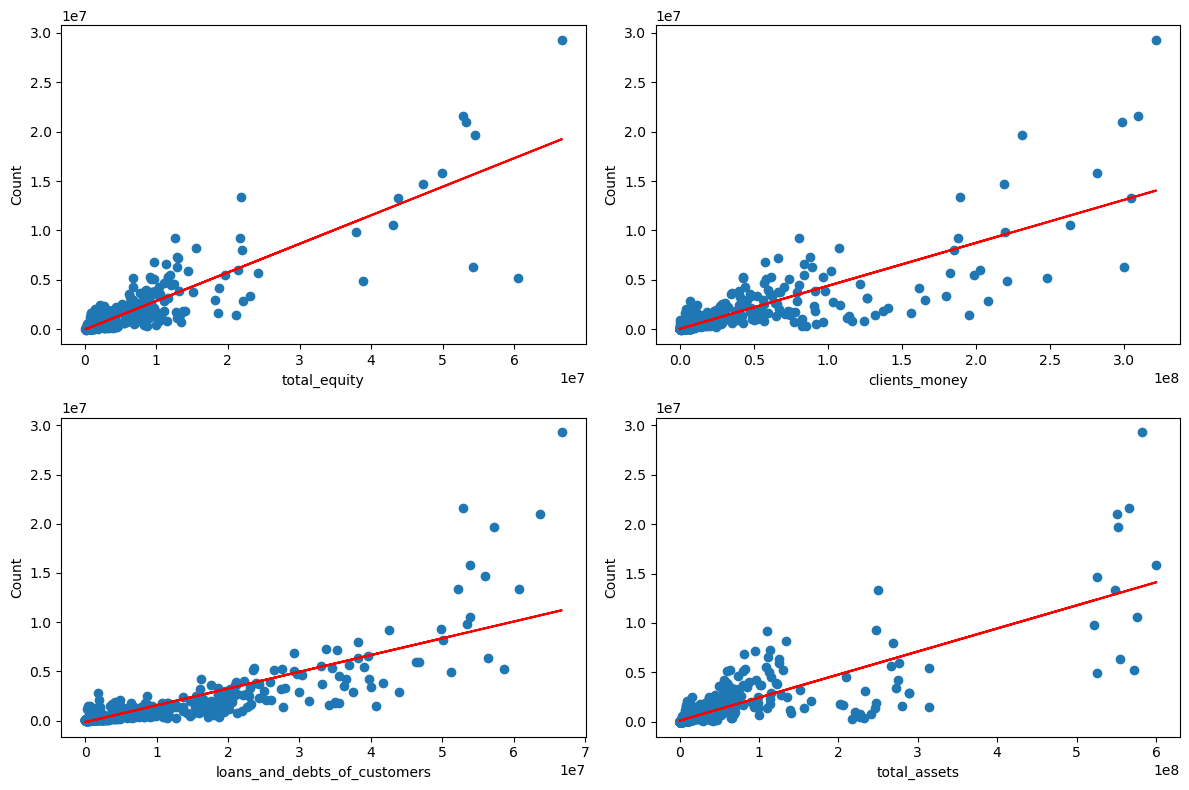

In [82]:
coef_dict = {}
for coef, feat in zip(reg.coef_, df.columns[1:]):
    coef_dict[feat] = coef

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for i, feature in enumerate(coef_dict):
    ax = axes[i // 2, i % 2]
    ax.scatter(df[feature], df['net_interest_income_expense'])
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')


    coeffs = np.polyfit(df[feature], df['net_interest_income_expense'], 1)
    line = np.polyval(coeffs, df[feature])
    ax.plot(df[feature], line, color='red')

plt.tight_layout()
plt.show()

Висновки:
Нажаль моя модель вийшла неефективною, бо вона має досить сильне відхилення.
Це сталося з наступних причин:
1. Недоученість моделі, для кращого прогнозування їх було недостання.
2. Кількість показників. Їх було недостатньо, треба було ускладнювати гіпотезу і збільшувати їх кількість.
3. Сама гіпотеза не є ідеальною, вона була би ефективнішою, якби не затрагувала всю банківську сферу України а була звужено до одного банку, бо банківська сфера України досить різна і висококонцентрована, через це створюється деякий дизбаланс в показниках.